In [60]:
import pandas as pd
import pypsa 
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
        "font.weight": "bold",  # bold fonts
        "font.size":10,
        "lines.linewidth": 2,   # thick lines
        "grid.color": "0.5",    # gray gridlines
        "grid.linewidth": 0.5,  # thin gridlines
        "savefig.dpi": 300,     # higher resolution output.
        "axes.labelsize" : 15
    })

In [61]:
csv_folder_name = "Data_Folder/Eastern_grid_data/Year_data"
network = pypsa.Network()
network.import_from_csv_folder(csv_folder_name)

Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 19, 3], imported network file PyPSA version [0, 18, 1].

INFO:pypsa.io:Imported network Year_data has buses, generators, lines, loads, storage_units, transformers


In [62]:
solar_inst_cost = 580000
hydro_inst_cost = 2135000#irena
road_per_km_cost = 85088 #article
substation_cost_per_mva = 29364#nea
line_cost_per_km_per_mw = 2100 #article
#40 per kW per year maintainance cost hydro irena 2021

In [63]:
#add capital cost and om cost of generators
#add cost to slack export positive import negative
network.generators['om_cost'] = np.zeros(len(network.generators))
for i in range(len(network.generators)):
    d_sub = network.generators.sub_dist[i]
    d_road = network .generators.road_dist[i]
    typ =network.generators.carrier[i]
    if typ == "Solar":
        network.generators.capital_cost[i] = d_sub * line_cost_per_km_per_mw*network.generators.p_nom[i] + d_road*road_per_km_cost + network.generators.p_nom[i]*solar_inst_cost + substation_cost_per_mva*network.generators.p_nom[i]/0.8
        network.generators.om_cost[i] = network.generators.p_nom[i]*14.1*1000
    if typ == "Hydro":
        network.generators.capital_cost[i] = d_sub * line_cost_per_km_per_mw*network.generators.p_nom[i] + d_road*road_per_km_cost + network.generators.p_nom[i]*hydro_inst_cost + substation_cost_per_mva*network.generators.p_nom[i]/0.8
        network.generators.om_cost[i] = network.generators.p_nom[i]*40*1000

/tmp/ipykernel_7098/3066983289.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_7098/3066983289.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_7098/3066983289.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_7098/3066983289.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyda

In [64]:
#updating network with optimal number of generators
def update_network(network,x_opt):
    network_new = network.copy()
    gen_off = np.where(x_opt == 0)
    network_new.generators=network_new.generators.drop(network_new.generators.index[gen_off], axis = 0)
    network_new.generators_t.p_max_pu = network_new.generators_t.p_max_pu.drop(network_new.generators_t.p_max_pu.columns[gen_off],axis= 1)
    return network_new

In [65]:
#from dry analysis
best_bits= np.array([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0])

In [66]:
optimal_network = update_network(network,best_bits)

In [67]:
#perform load flow for differernt generation and load condition
def data_norm(Network_data):
    for i in range(len(Network_data.snapshots)):
        snapshot = Network_data.snapshots[i]
        Network_data.generators_t.p_max_pu.iloc[i] = Network_data.generators.p_nom*Network_data.generators_t.p_max_pu.iloc[i] #updating the geneation with max geneartiaon
    return Network_data

In [68]:
optimal_network = data_norm(optimal_network)

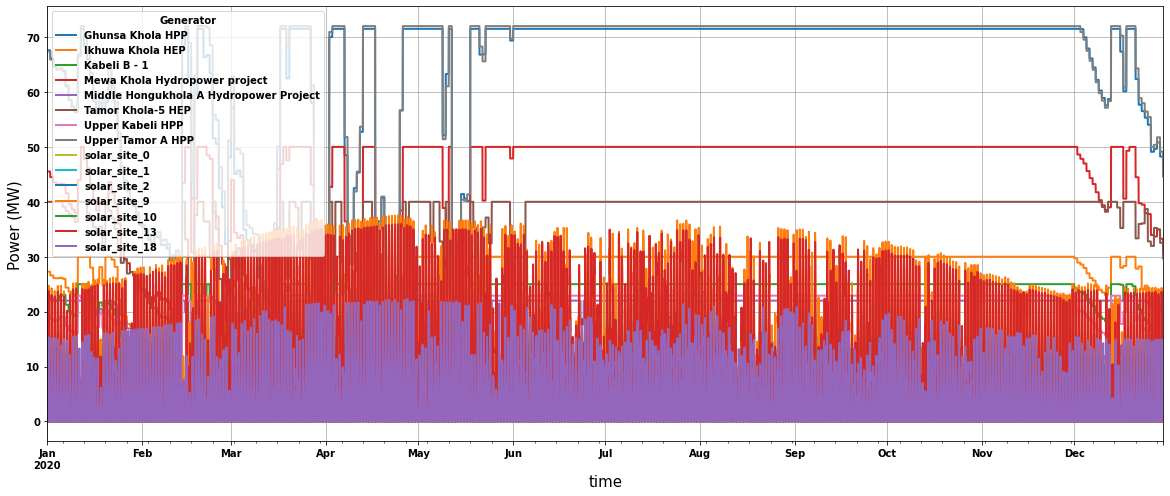

In [15]:
fig,ax = plt.subplots(figsize = (20,8))
optimal_network.generators_t.p_max_pu.plot(ax=ax)
ax.set_xlabel("time")
ax.set_ylabel("Power (MW)")
ax.grid()
plt.savefig("Images/year_generation.jpg",dpi = 300,bbox_inches = 'tight')

In [78]:
cost_data = pd.DataFrame()
cost_data.index = optimal_network.generators_t.p_max_pu.index
cost_data['Total Generation'] = optimal_network.generators_t.p_max_pu.sum(axis = 1)*0.9

<AxesSubplot:xlabel='snapshot'>

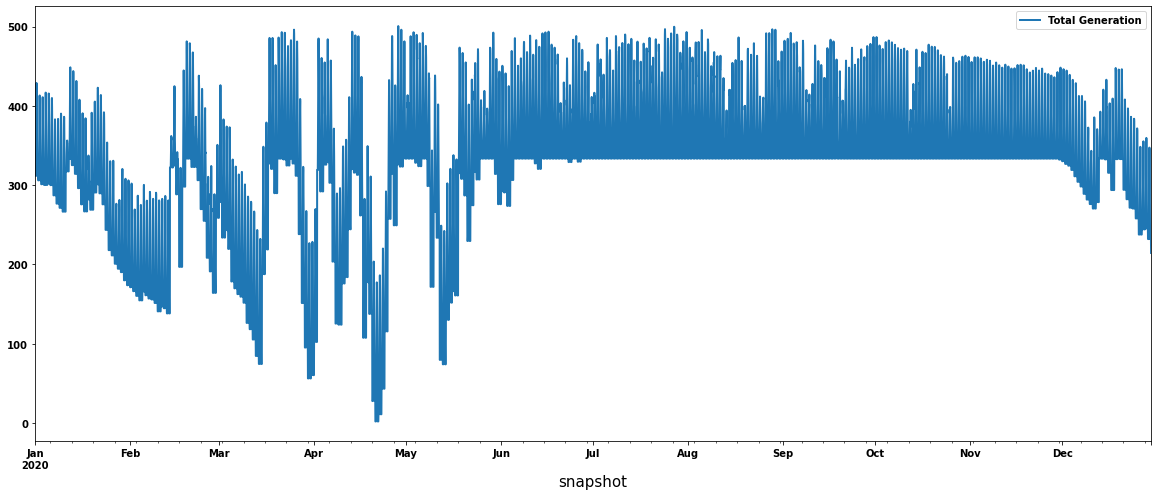

In [72]:
fig,ax = plt.subplots(figsize = (20,8))
cost_data.plot(ax = ax)

In [79]:
dr = 0.1
n = 25
crf = (dr*(1+dr)**n)/(((1+dr)**n)-1)

In [80]:
yearly_energy_kwh = cost_data['Total Generation'].sum()*1000
capital_cost = optimal_network.generators.capital_cost.sum()
yearly_om_cost = optimal_network.generators.om_cost.sum()

In [88]:
Lcoe = (capital_cost*crf + yearly_om_cost)/(yearly_energy_kwh)

In [101]:
Lcoe = pd.DataFrame()
Lcoe['LCOE'] = (optimal_network.generators.capital_cost*crf + optimal_network.generators.om_cost)/(optimal_network.generators_t.p_max_pu.sum()*1000)

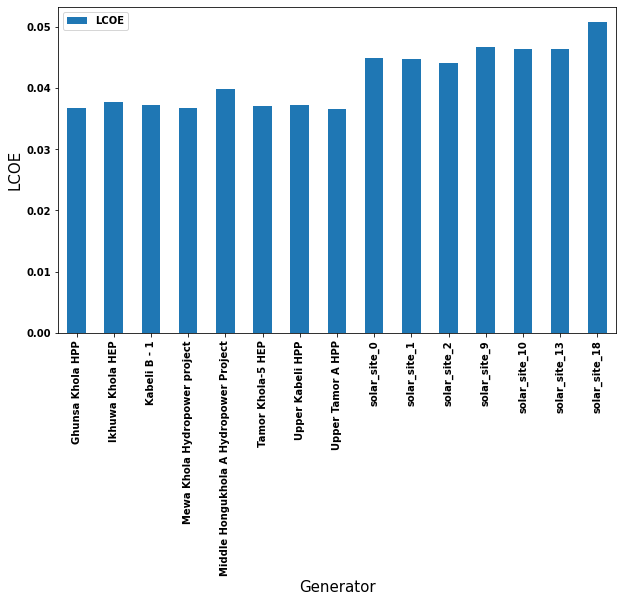

In [110]:
fig,ax = plt.subplots(figsize = (10,6))
Lcoe.plot.bar(ax=ax)
ax.set_ylabel("LCOE")
plt.savefig("Images/lcoe.jpg",dpi = 300,bbox_inches = 'tight')

In [77]:
yearly_om_cost/crf

143737971.28482795